In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Problem 1 to 7 is in the implementation of Scratch K-Means

In [49]:
class ScratchKMeans():
  """
  K-means scratch implementation
  Parameters
  ----------
  n_clusters : int
    Number of clusters
  n_init : int
    How many times to change the initial value of the center point for calculation
  max_iter : int
    Maximum number of iterations in one calculation
  tol : float
    Margin of error between the center point and the center of gravity, which is the reference for ending the iteration
  verbose : bool
    True to output the learning process
  """
  def __init__(self, n_clusters=3, n_init=10, max_iter=100, tol=1e-3, verbose=False):
    # Record hyperparameters as attributes
    self.n_clusters = n_clusters
    self.n_init = n_init
    self.max_iter = max_iter
    self.tol = tol
    self.verbose = verbose

  def _distance_to_center(self, data_point, center_point):
    return np.linalg.norm(data_point - center_point) ** 2
    
  def _sse(self, X):
    labels = self.predict(X)
    sse = sum([self._distance_to_center(x, self.centers[k]) for x, k in zip(X, labels)])
    return sse

  def _init_centers(self, X):
    assert self.n_clusters > 1 and self.n_clusters <= X.shape[0], "Invalid number of clusters"
    return X[np.random.choice(a=X.shape[0], size=self.n_clusters, replace=False)]

  def _arrange_centers(self, X):
    labels = self.predict(X)
    centers = self.centers.copy()
    for k in np.unique(labels):
      X_k = X[labels == k, :]
      centers[k, :] = np.mean(X_k, axis=0)
    return centers

  def fit(self, X):
    """
    Calculate clustering by K-means
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
        Features of training data
    """
    self.center = self._init_centers(X)
    sse_record = []         # keep track of sse
    centers_record = []     # keep track of center

    for i in range(self.n_init):
      # Init centers
      self.centers = self._init_centers(X)

      # Iterate 
      for j in range(self.max_iter):
        new_centers = self._arrange_centers(X)
        if (abs(new_centers - self.centers) < self.tol).all():
            break
        self.centers = new_centers
      sse = self._sse(X)
      sse_record.append(sse)
      centers_record.append(self.center.copy())

    idx = np.argmin(sse_record)
    self.cluster_centers_ = centers_record[idx]
    self.inertia_ = sse_record[idx]
    self.labels_ = self.predict(X)

    return self

  def predict(self, X):
    """
    Calculate which cluster the input data belongs to
    """
    labels = np.zeros(X.shape[0],dtype=int)
    for i in range(X.shape[0]):
      distance_to_centers = [self._distance_to_center(X[i,:], center) for center in self.centers]
      labels[i] = np.argmin(distance_to_centers)
    return labels

## **Problem 8**
## Implementation of elbow method

In [50]:
def elbow_method(X, model, max_iter):
  sse = []
  x = range(2,max_iter)
  for i in range(2,max_iter):
    model.n_clusters = i
    model.fit(X)
    sse.append(model.inertia_)
  plt.plot(x, sse, 'bx-', marker='o')
  plt.xlabel('Number of clusters')
  plt.ylabel('SSE')
  plt.title('The Elbow Method using SSE')
  plt.show()

In [51]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

Elbow diagram for the scratch model

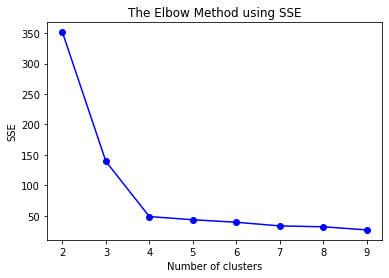

In [52]:
scratchKMean = ScratchKMeans()
elbow_method(X, scratchKMean, max_iter=10)

Elbow diagram for the Scikit-learn model

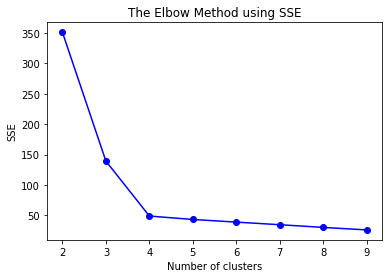

In [53]:
from sklearn.cluster import KMeans
scikitKMean = KMeans()
elbow_method(X, scikitKMean, max_iter=10)

## **Problem 9**
## (Advance assignment) Silhouette diagram

In [54]:
from matplotlib import cm

def compute_silhouette(X, labels):
    def cohesion(X_k):
        def mean_D(a, X_k):
            return sum(np.linalg.norm(a - b) for b in X_k) / (len(X_k) - 1)
        return np.array([mean_D(x, X_k) for x in X_k])

    def divergence_degree(label_k):
        def mean_D(a, X_k):
            return sum(np.linalg.norm(a - b) for b in X_k) / len(X_k)
        def b(x):
            return [mean_D(x, X[labels == l]) for l in np.unique(labels)
                                                if l != label_k]
        return np.array([min(b(x)) for x in X[labels == label_k]])

    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])
    for label in np.unique(labels):
        a[labels == label] = cohesion(X[labels == label])
        b[labels == label] = divergence_degree(label)
    s = (b - a) / np.maximum(a, b)
    return s, np.mean(s)

def plot_silhouette(silhouette_vals, silhouette_avg, y_km,
                    cluster_labels, n_clusters):
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

In [55]:
scratchKMean = ScratchKMeans(n_clusters=4)
scikitKMean = KMeans(n_clusters=4)

scratchKMean.fit(X)
scikitKMean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [56]:
from sklearn.metrics import silhouette_score

scratchScore = silhouette_score(X, scratchKMean.labels_, random_state=0)
sklearnScore = silhouette_score(X, scikitKMean.labels_, random_state=0)
scratch_score_vals, scratch_score_avg = compute_silhouette(X, scratchKMean.labels_)
sklearn_score_vals, sklearn_score_avg = compute_silhouette(X, scikitKMean.labels_)

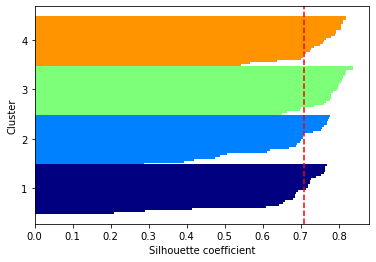

In [57]:
plot_silhouette(scratch_score_vals, scratch_score_avg, scratchKMean.labels_,
                np.arange(scratchKMean.n_clusters), scratchKMean.n_clusters)

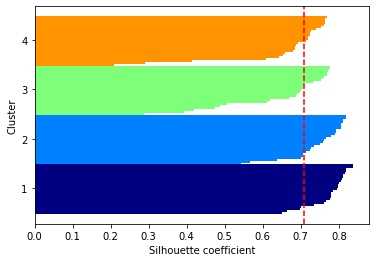

In [58]:
plot_silhouette(sklearn_score_vals, sklearn_score_avg, scikitKMean.labels_,
                np.arange(scikitKMean.n_clusters), scikitKMean.n_clusters)

# **Cluster analysis**

In [59]:
from sklearn.decomposition import PCA

def display_distributed_explanation_rate_PCA(data):
  pca = PCA(n_components=None)
  pca = pca.fit(data)
  var_exp = pca.explained_variance_ratio_
  cum_var_exp = np.cumsum(var_exp)
  print(cum_var_exp)
  plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
  plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal components')
  plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

In [60]:
import pandas as pd

df = pd.read_csv('Wholesale_customers_data.csv')
data = df.drop(columns=["Channel", "Region"])
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


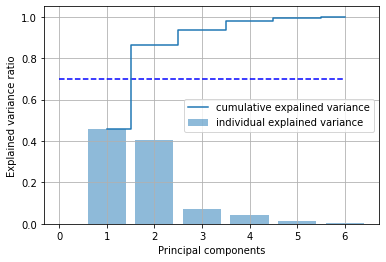

In [61]:
display_distributed_explanation_rate_PCA(data)

In [62]:
pca = PCA(n_components=2)
pca = pca.fit(data)
data_reduced = pca.transform(data)

## **Problem 10**
## Selection of the number of clusters k

### Using the Elbow method

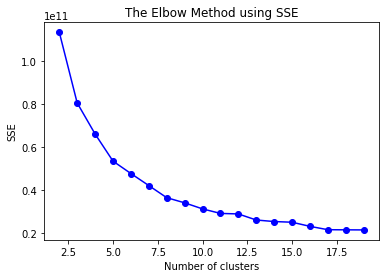

In [63]:
elbow_method(data.values, ScratchKMeans(), 20)

### Using Silhouette Method

In [64]:
def silhouette_method(X, model, max_iter):
  for i in range(2,max_iter):
    model.n_clusters = i
    model.fit(X)
    score = silhouette_score(X, model.labels_, random_state=0)
    score_vals, score_avg = compute_silhouette(X, model.labels_)
    plot_silhouette(score_vals, score_avg, model.labels_,
                np.arange(model.n_clusters), model.n_clusters)

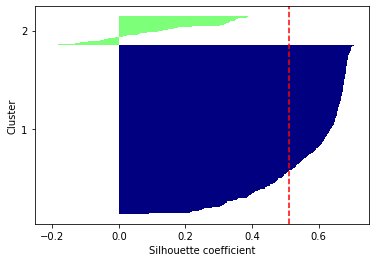

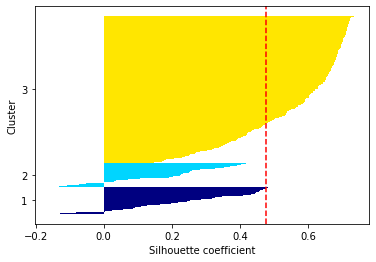

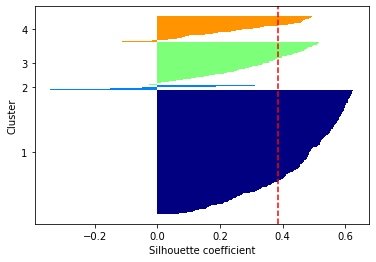

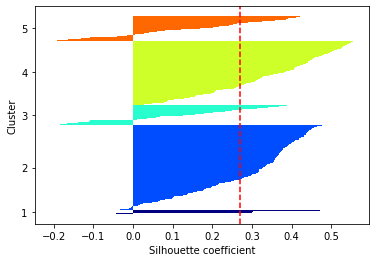

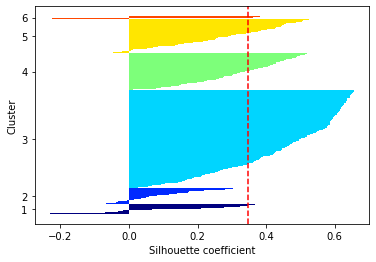

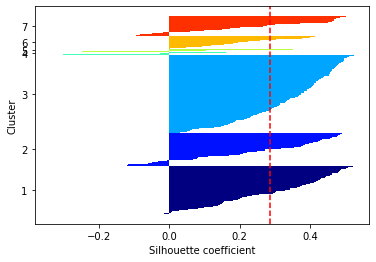

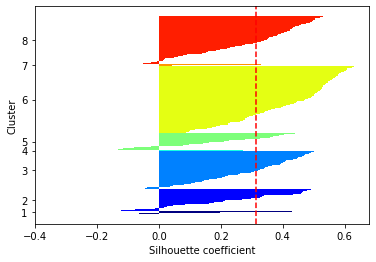

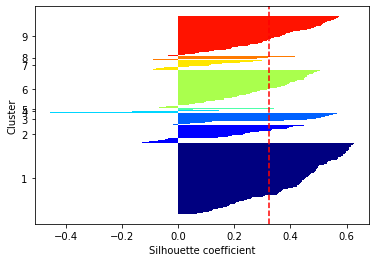

In [65]:
model = ScratchKMeans()

silhouette_method(data.values, model, 10)

From the elbow diagram, we can see that the elbow is at 2 or 3 number of clusters. From the Silhouette diagram, the number of clusters that provides the highest coefficient is 3, so I will choose **K (number of clusters) = 3**

##**Problem 11**
##Comparison with known groups

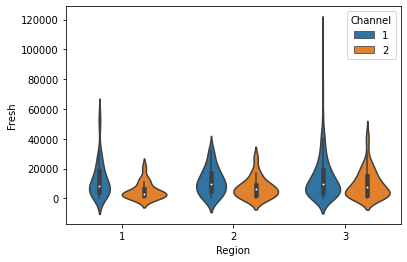

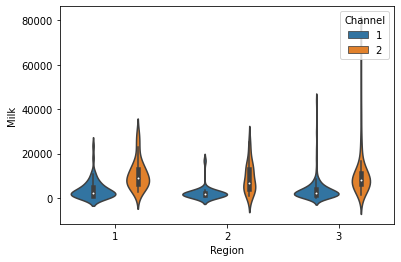

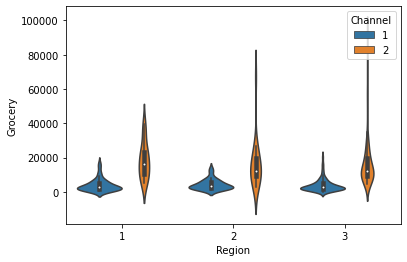

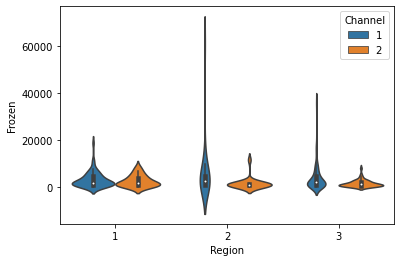

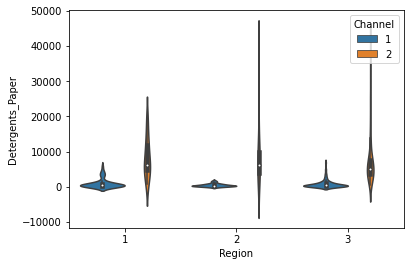

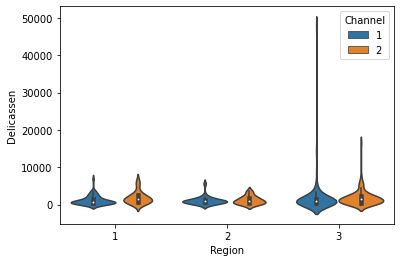

In [66]:
cols = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
for col in cols:
    sns.violinplot(x="Region", y=col, hue="Channel", data=df)
    plt.show()

##**Problem 12**
##Useful information for wholesalers

In [67]:
kmeans = ScratchKMeans(n_clusters=3).fit(data.values)
df["label"] = kmeans.labels_

In [68]:
df.groupby(by=['Region', 'Channel']).describe()

Fresh                                     ... label               
                count          mean           std    min  ...   25%  50%  75%  max
Region Channel                                            ...                     
1      1         59.0  12902.254237  12342.008901  514.0  ...   0.0  0.0  0.0  2.0
       2         18.0   5200.000000   5415.521495   18.0  ...   0.0  1.5  2.0  2.0
2      1         28.0  11650.535714   8969.362752    3.0  ...   0.0  0.0  0.0  1.0
       2         19.0   7289.789474   6867.934548  161.0  ...   0.0  0.0  2.0  2.0
3      1        211.0  13878.052133  14746.572913    3.0  ...   0.0  0.0  0.0  2.0
       2        105.0   9831.504762   9635.394129   23.0  ...   0.0  0.0  2.0  2.0

[6 rows x 56 columns]

In [69]:
df.drop(columns=["Channel", "Region"]).groupby(by=["label"]).describe()

Fresh                             ... Delicassen                 
       count         mean           std  ...        50%     75%      max
label                                    ...                            
0      317.0   7655.48265   5679.696845  ...      776.0  1522.0  14472.0
1       73.0  33111.69863  14971.377838  ...     1404.0  2564.0  14351.0
2       50.0   8723.78000   9930.130189  ...     1485.5  2925.5  47943.0

[3 rows x 48 columns]

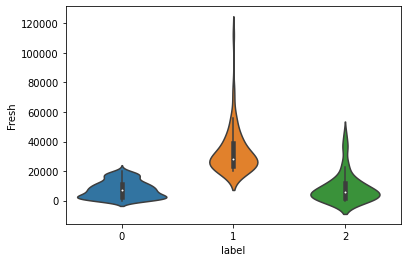

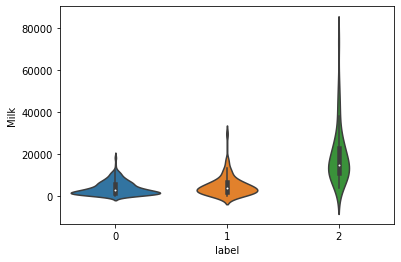

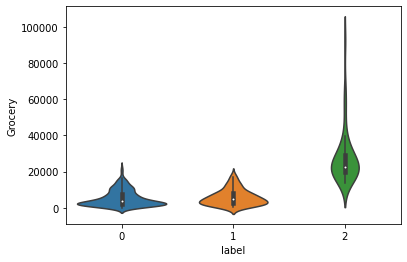

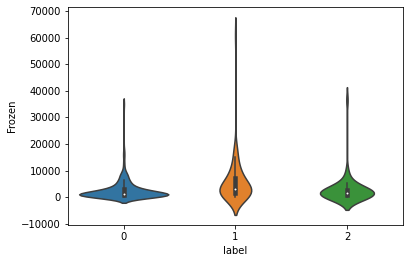

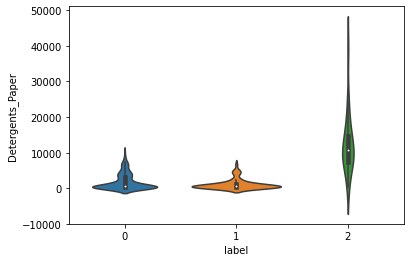

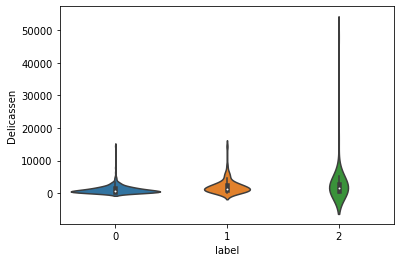

In [70]:
cols = ["Fresh", "Milk", "Grocery", "Frozen",
        "Detergents_Paper", "Delicassen"]
for col in cols:
    sns.violinplot(x="label", y=col, data=df)
    plt.show()

Analyse based on 3 clusters:

1.   Cluster 0: high interest in **Milk**, **Grocery**, **Detergents_Paper** and spend little money on **Fresh**, but in a high frequency.
2.   Cluster 1: high interest in **Fresh**, overall spend low money on wholesale products.
3.   Cluster 2: buy a lot of **Fresh**, **Frozen** and **Delicassen**

Analyse based on 'Channel' and 'Region':

1.   Region 1: buy a fair amount of products, but spend mostly in **Fresh**, **Milk** and **Grocery**.
2.   Region 2: does not buy a lot products, but spend a lot in **Fresh**, comparing to other regions (like cluster 1).
3.   Region 3: buy a lot of everything.